# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [4]:
import nltk
nltk.download(['punkt', 'wordnet','stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lamiakasmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lamiakasmi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lamiakasmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [203]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.grid_search import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 20),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [213]:
# load data from database
def load_data():
    engine = create_engine('sqlite:///DisasterResponse.db')
    df = pd.read_sql_table('Messages',engine)
    X = df['message']
    Y = df.iloc[:,4:].drop(columns='child_alone')
    return X,Y
X,Y = load_data()

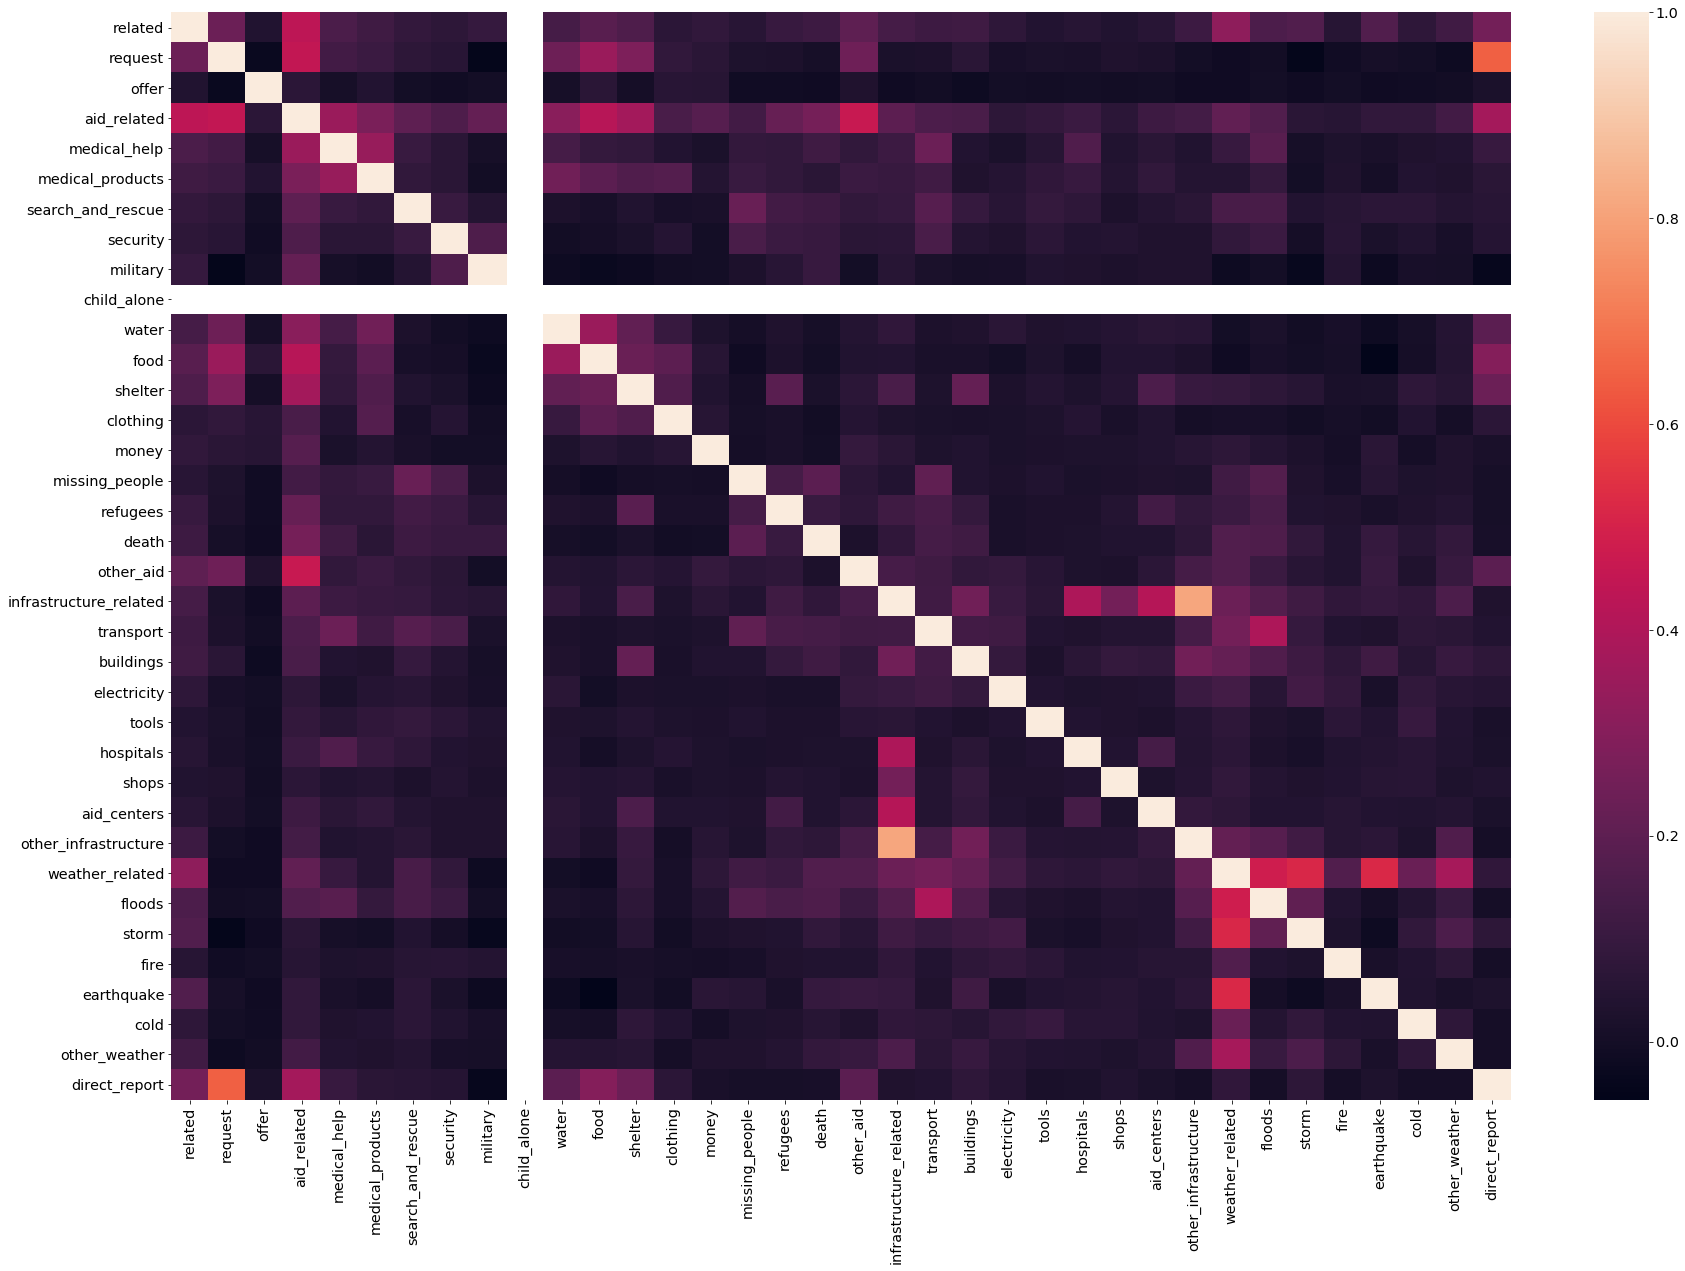

In [202]:
sns.heatmap(Y.corr()) 

In [159]:
type(forbidden_index)

list

In [96]:
def resample_data(X,Y):
    categories = Y.columns.tolist()
    occurences = Y.sum()
    
    occurences.sort_values(ascending=False).plot.bar();
    
    occurences_pct = occurences/Y.shape[0]
    
    for c,p in zip()

    

In [186]:
Y[Y['related'] ==0].sum()

related                   0
request                   0
offer                     0
aid_related               0
medical_help              0
medical_products          0
search_and_rescue         0
security                  0
military                  0
child_alone               0
water                     0
food                      0
shelter                   0
clothing                  0
money                     0
missing_people            0
refugees                  0
death                     0
other_aid                 0
infrastructure_related    0
transport                 0
buildings                 0
electricity               0
tools                     0
hospitals                 0
shops                     0
aid_centers               0
other_infrastructure      0
weather_related           0
floods                    0
storm                     0
fire                      0
earthquake                0
cold                      0
other_weather             0
direct_report       

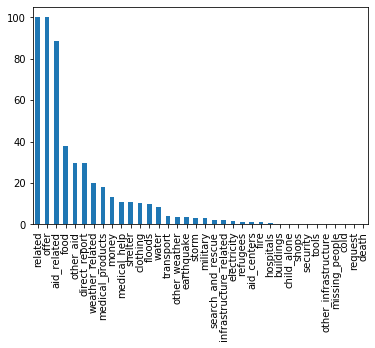

In [173]:
categories = Y.columns.tolist()
occurences = Y.sum()
#occurences.sort_values(ascending=False).plot.bar();
occurences_pct = occurences/Y.shape[0]*100
#occurences_pct.sort_values(ascending=False).plot.bar();
occurence_target = int(Y.shape[0]/len(categories))
categories_to_upsample = occurences[occurences <= occurence_target].index.tolist()
categories_to_downsample = occurences[occurences > occurence_target].index.tolist()

index = []
for c in categories_to_upsample:
    partial_df = Y[Y[c] == 1 ]
    if partial_df.shape[0] >0:
        sample_df = partial_df.sample(replace=True,n=occurence_target).reset_index()
        index.append(sample_df['index'].tolist())
        
for c in categories_to_downsample:
    forbidden_index = sorted(list(set(index[0])))
    remaining_index = Y.index.tolist()
    for f in forbidden_index:
        remaining_index.remove(f)
        
    partial_df = Y.iloc[remaining_index][Y.iloc[remaining_index][c] == 1]
    if partial_df.shape[0] >0:
        sample_df = partial_df.sample(replace=True,n=occurence_target).reset_index()
        index.append(sample_df['index'].tolist())
    

X_new = X[index[0]]
Y_new = Y.iloc[index[0]]

occurences_new = Y_new.sum()
#occurences.sort_values(ascending=False).plot.bar();
occurences_pct_new = occurences_new/Y_new.shape[0]*100

occurences_pct_new.sort_values(ascending=False).plot.bar();

In [172]:
Y.iloc[remaining_index][Y.iloc[remaining_index]['related']==1]

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26208,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26210,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26213,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26214,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


26216 118 26098


In [ ]:
Y.index.tolist() 

In [131]:
partial_df = Y[Y['child_alone'] == 1]
partial_df.shape[0]

0

In [110]:
categories_to_upsample = occurences[occurences <= occurence_target].index.tolist()
categories_to_upsample

['offer',
 'search_and_rescue',
 'security',
 'child_alone',
 'clothing',
 'money',
 'missing_people',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'fire',
 'cold']

In [111]:
categories_to_downsample = occurences[occurences > occurence_target].index.tolist()
categories_to_downsample

['related',
 'request',
 'aid_related',
 'medical_help',
 'medical_products',
 'military',
 'water',
 'food',
 'shelter',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'earthquake',
 'other_weather',
 'direct_report']

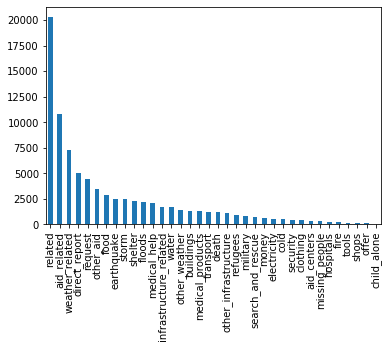

In [67]:
Y.sum().sort_values(ascending=False).plot.bar()

In [ ]:
#upsampling 


### 2. Write a tokenization function to process your text data

In [7]:
def tokenize(text):
    text = re.sub(r"[^a-zA-Z0-9]"," ",text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [68]:
def build_pipeline():
    model = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('clf', MultiOutputClassifier(RandomForestClassifier()))
                        ])
    return model

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [69]:
model_RF = build_pipeline()

In [71]:
model_RF.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x1c1d508ea0>, vocabulary=None)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False),
              n_jobs=1))],
 'vect': CountVectorizer(

In [6]:
def train(X,Y,model):
    X_train, X_test, y_train, y_test = train_test_split(X,Y) 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = y_test.columns)
    return X_train, X_test, y_train, y_test, y_pred
model = build_pipeline()
X_train, X_test, y_train, y_test, y_pred = train(X,Y,model)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [16]:
def display_results(y_test, y_pred):
    for i in range(y_test.shape[1]):
        print(70*'='+'\nFeature: ',Y.columns[i])
        print(classification_report(y_test.iloc[:,i],y_pred.iloc[:,i]))OneVsRestClassifier

In [7]:

display_results(y_test,y_pred)

Feature:  related
             precision    recall  f1-score   support

          0       0.61      0.48      0.54      1537
          1       0.85      0.90      0.87      4965
          2       0.30      0.29      0.29        52

avg / total       0.79      0.80      0.79      6554

Feature:  request
             precision    recall  f1-score   support

          0       0.90      0.97      0.93      5444
          1       0.77      0.46      0.57      1110

avg / total       0.88      0.88      0.87      6554

Feature:  offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6525
          1       0.00      0.00      0.00        29

avg / total       0.99      1.00      0.99      6554

Feature:  aid_related
             precision    recall  f1-score   support

          0       0.76      0.85      0.80      3891
          1       0.73      0.60      0.66      2663

avg / total       0.75      0.75      0.74      6554

Feature:  med

/Users/lamiakasmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [34]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
def build_pipeline():
    pipeline = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('clf', MultiOutputClassifier(GBC()))
                        ])
    return pipeline

# next: use MultiOutputClassifier

In [44]:
def build_model():
    pipeline = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('clf', MultiOutputClassifier(GBC()))
                        ])
    
    parameters = {
                'vect__max_features': (None, 5000, 10000),
                'clf__estimator__n_estimators': [50, 100],
                'clf__estimator__min_samples_split': [2, 3]
    }
    
    parameters = {
        'clf__estimator__learning_rate':[0.1],
        'clf__estimator__n_estimators': [100],
    }

    cv = GridSearchCV(pipeline, param_grid=parameters)
    return cv

In [223]:
def build_model():
    pipeline = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('clf', MultiOutputClassifier(OneVsRestClassifier(RandomForestClassifier())))
                        ])
    return pipeline

In [224]:
def train_model(X,Y,model):
    X_train, X_test, y_train, y_test = train_test_split(X,Y) 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = y_test.columns)    
    return X_train, X_test, y_train, y_test, y_pred

model = build_model()
X_train, X_test, y_train, y_test, y_pred = train_model(X,Y,model)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [225]:
# MultiOutputClassifier(OneVsRestClassifier(RandomForestClassifier()))
display_results(y_test,y_pred)

Feature:  related
             precision    recall  f1-score   support

          0       0.71      0.41      0.52      1528
          1       0.84      0.94      0.89      4978
          2       0.26      0.33      0.29        48

avg / total       0.80      0.82      0.80      6554

Feature:  request
             precision    recall  f1-score   support

          0       0.89      0.98      0.93      5428
          1       0.81      0.42      0.56      1126

avg / total       0.88      0.88      0.87      6554

Feature:  offer
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      6517
          1       0.00      0.00      0.00        37

avg / total       0.99      0.99      0.99      6554

Feature:  aid_related
             precision    recall  f1-score   support

          0       0.76      0.86      0.80      3855
          1       0.75      0.61      0.67      2699

avg / total       0.75      0.76      0.75      6554

Feature:  med

/Users/lamiakasmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Feature:  other_infrastructure
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      6280
          1       0.20      0.00      0.01       274

avg / total       0.93      0.96      0.94      6554

Feature:  weather_related
             precision    recall  f1-score   support

          0       0.87      0.96      0.91      4723
          1       0.85      0.62      0.72      1831

avg / total       0.86      0.86      0.86      6554

Feature:  floods
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      6013
          1       0.87      0.34      0.49       541

avg / total       0.94      0.94      0.93      6554

Feature:  storm
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      5914
          1       0.81      0.46      0.59       640

avg / total       0.93      0.94      0.93      6554

Feature:  fire
             precision    recall  f

In [222]:
# MultiOutputClassifier(OneVsRestClassifier(SVC))
display_results(y_test,y_pred)

Feature:  related
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1519
          1       0.76      1.00      0.86      4989
          2       0.00      0.00      0.00        46

avg / total       0.58      0.76      0.66      6554

Feature:  request
             precision    recall  f1-score   support

          0       0.83      1.00      0.90      5412
          1       0.00      0.00      0.00      1142

avg / total       0.68      0.83      0.75      6554

Feature:  offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6522
          1       0.00      0.00      0.00        32

avg / total       0.99      1.00      0.99      6554

Feature:  aid_related
             precision    recall  f1-score   support

          0       0.58      1.00      0.74      3825
          1       0.00      0.00      0.00      2729

avg / total       0.34      0.58      0.43      6554

Feature:  med

/Users/lamiakasmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [216]:
# MultioutputClassifier(SVC)
display_results(y_test,y_pred)

Feature:  related
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1511
          1       0.76      1.00      0.86      4990
          2       0.00      0.00      0.00        53

avg / total       0.58      0.76      0.66      6554

Feature:  request
             precision    recall  f1-score   support

          0       0.83      1.00      0.91      5454
          1       0.00      0.00      0.00      1100

avg / total       0.69      0.83      0.76      6554

Feature:  offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6526
          1       0.00      0.00      0.00        28

avg / total       0.99      1.00      0.99      6554

Feature:  aid_related
             precision    recall  f1-score   support

          0       0.59      1.00      0.74      3859
          1       0.00      0.00      0.00      2695

avg / total       0.35      0.59      0.44      6554

Feature:  med

/Users/lamiakasmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
# MultioutputClassifier(GradientBoostingClassifier)
display_results(y_test,y_pred)

Feature:  related
             precision    recall  f1-score   support

          0       0.66      0.27      0.38      1477
          1       0.81      0.96      0.88      5032
          2       0.39      0.20      0.26        45

avg / total       0.78      0.80      0.76      6554

Feature:  request
             precision    recall  f1-score   support

          0       0.91      0.96      0.93      5416
          1       0.73      0.53      0.62      1138

avg / total       0.88      0.88      0.88      6554

Feature:  offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6524
          1       0.00      0.00      0.00        30

avg / total       0.99      0.99      0.99      6554

Feature:  aid_related
             precision    recall  f1-score   support

          0       0.75      0.85      0.80      3804
          1       0.75      0.60      0.66      2750

avg / total       0.75      0.75      0.74      6554

Feature:  med

In [27]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.74      0.18      0.30      1580
          1       0.78      0.98      0.87      4932
          2       0.50      0.14      0.22        42

avg / total       0.77      0.78      0.73      6554



### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [36]:
def display_results(y_test, y_pred):
    for i in range(y_test.shape[1]):
        print(70*'='+'\nFeature: ',Y.columns[i])
        print(classification_report(y_test.iloc[:,i],y_pred.iloc[:,i]))

In [37]:
display_results(y_test,y_pred)

Feature:  related
             precision    recall  f1-score   support

          0       0.62      0.35      0.45      1504
          1       0.83      0.93      0.88      5013
          2       0.48      0.38      0.42        37

avg / total       0.78      0.80      0.78      6554

Feature:  request
             precision    recall  f1-score   support

          0       0.89      0.98      0.93      5455
          1       0.83      0.39      0.53      1099

avg / total       0.88      0.88      0.87      6554

Feature:  offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6529
          1       0.00      0.00      0.00        25

avg / total       0.99      1.00      0.99      6554

Feature:  aid_related
             precision    recall  f1-score   support

          0       0.73      0.87      0.80      3839
          1       0.75      0.55      0.64      2715

avg / total       0.74      0.74      0.73      6554

Feature:  med

/Users/lamiakasmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.